# Model Training

This notebook trains the LSTM (Long Short Term memory) model to predict the ratings of a given review. <br>

All the cells of the notebook can be executed in a single run. There are few cells, which trains the LSTM model which might take few time for execution based on the number of epochs given.

In [ ]:
from pprint import pprint
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# Necessary package installations



In [ ]:
!pip install keras

# Mounting drive to colab

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Loading stored Data

The following data are stored as pickled files for future use. 
1. cleaned training data
2. cleaned test data
3. training labels (yactual)
4. test labels (ytest)
5. tfidf vectors of all data (train_tfidf, test_tfidf, val_tfidf)

Storing pickle files helps to easily load the data for later use without executing all the code snippets again. <br>

Note: change the file path accordingly

In [ ]:
#Reading pickled train data
with open ('/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/yelptraindata1.pkl', 'rb') as fp:
    train_data = pickle.load(fp)

train_data[:5]

['dismal lukewarm glop waiter manager see us barely nibble entree plate shove forward pickup thank us perfunctorily patronage hill country jail serve grub bad protection never never never back yard house real food',
 'love really atmosphere cozy festive shrimp house fry fry sometimes good sometimes great spicy dipping sauce come die beer list amazing cocktail great price cheap dive go every week rather treat try will not disappoint',
 'actually horrify place still business year old son need haircut past summer lure cut sign get door wait minute stylist work people place total garbage tacky sofa time sofa giant son notice ant crawl floor furniture disgusting walk actually turn around walk upon enter do not old black male stylist finish haircut turn tell want clipper around back side hand cut top standard boy cut really freak simple right wrong rather use clipper go actually cut hair go use move downward do not cut hair rub man allege cosmetology license know use set clipper realize almo

In [ ]:
#Reading pickled test data
with open ('/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/yelptestdata1.pkl', 'rb') as fp:
    xtest = pickle.load(fp)

xtest[:5]

['go bunch friend amazing time diva fun show professional cast dancer together th queen true character blow us away frank us laugh entire show well would advise anyone everyone come show',
 'place amazing fry chicken good day get rice come piece chicken purple rice delicious can not describe super crispy also super juicy drizzle chicken sauce like mayonnaise blow mind excited eat forget take picture fear ill back sure',
 ' year old washing machine repair actually good experience call late yesterday come today time say would think serviceman positive anyway super courteous waste time find problem show debris line water backing definitely recommend affordable appliance use hopefully will not need near future also service fee go toward repair lot less company call',
 'broil haddock good stuff mushroom outstanding good brandy old fashioned obviously popular destination make reservation content mill around bar bit nice atmosphere work casual night right water go back',
 'love bar bartender 

In [ ]:
#loading stored training and test labels
yactual = pickle.load(open("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/yelptrainlabels.pkl", "rb"))
print(f"The length of training labels is {len(yactual)}")
ytest = pickle.load(open("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/yelptestlabels.pkl", "rb"))
print(f"The length of test labels is {len(ytest)}")

The length of training labels is 599995
The length of test labels is 149995


In [ ]:
#loading data tfidf vectors
xtrain_tfidf = pickle.load(open("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/train_tfidf.pkl", "rb"))
xval_tfidf = pickle.load(open("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/val_tfidf.pkl", "rb"))
xtest_tfidf = pickle.load(open("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/test_tfidf.pkl", "rb"))

In [ ]:
xtraindr = pickle.load(open("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/xtraindr.pkl", "rb"))
print(f"xtraindr shape: {xtraindr.shape}")
xvaldr = pickle.load(open("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/xvaldr.pkl", "rb"))
print(f"xvaldr shape: {xvaldr.shape}")
xtestdr = pickle.load(open("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/xtestdr.pkl", "rb"))
print(f"xtestdr shape: {xtestdr.shape}")

xtraindr shape: (479996, 100)
xvaldr shape: (119999, 100)
xtestdr shape: (149995, 100)


In [ ]:
print(f"xtraindr shape: {xtraindr.shape}")
print(f"xvaldr shape: {xvaldr.shape}")
print(f"xtestdr shape: {xtestdr.shape}")

xtraindr shape: (479996, 100)
xvaldr shape: (119999, 100)
xtestdr shape: (149995, 100)


# Train test split

In [ ]:
#splitting into training and validation data
from sklearn.model_selection import train_test_split

xtrain, xval, ytrain, yval = train_test_split(train_data, yactual, test_size=0.2, random_state=42)
#TODO: not sure of using shape, need to verify that
# print(xtrain.shape)
# print(xval.shape)
# print(ytrain.shape)
# print(yval.shape)

In [ ]:
print(f"The length of the training data is {len(xtrain)}")
print(f"The length of the validation data is {len(xval)}")

The length of the training data is 479996
The length of the validation data is 119999


# Model performance analysis

In [ ]:
# Squared error
# Regression error metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

def evaluate_model(ytrain, ypred):
    mse = mean_squared_error(ytrain, ypred)
    print(f"Mean squared error: {mse}")
    mae = mean_absolute_error(ytrain, ypred)
    print(f"Mean absolute error: {mae}")
    r2 = r2_score(ytrain, ypred)
    print(f"r2 score: {r2}")
    rmse = np.sqrt(mse)
    print(f"Root mean squared error: {rmse}")

    return rmse, mse, mae, r2

# Buliding Regression models

## LSTM model

In [ ]:
!ls

gdrive		   glove.6B.200d.txt  glove.6B.50d.txt
glove.6B.100d.txt  glove.6B.300d.txt  sample_data


In [ ]:
#embedding dict generation to feed embedding initializer for deep learning models
#the line below is one of the lines in glove 100d file
#homeboy 0.67496 0.29422 0.59005 -0.41164 0.01012 -0.32458 0.26266 0.029097 -0.14554 0.81735 -0.53338 -0.58159 -0.094172 -0.20248 -0.083792 -0.0095992 0.25925 -0.11928 0.3484 -0.17698 0.37354 -0.12536 -0.49478 -0.28594 0.16181 0.54977 0.33072 -0.34515 -0.16357 -0.23068 0.25828 0.0058146 0.32245 0.00025066 -0.70428 0.57681 -0.32714 -0.14952 0.17887 -0.29161 0.10076 0.46869 0.2262 0.23153 -0.09464 -0.3792 -0.42819 0.92064 0.3248 0.20705 -0.6283 0.21868 -0.47819 -0.37023 -0.10896 0.83518 0.3544 0.32274 -0.35379 -0.14564 0.35321 -0.41624 -0.14208 0.32608 0.2653 0.16914 0.44137 -0.2317 -0.17613 0.035587 0.42986 0.057176 0.29689 -0.79063 0.15307 0.33647 0.79888 -0.18556 0.48422 -0.11913 -0.45485 -0.03383 -0.41176 0.13156 0.14596 -0.036701 -0.20716 -0.31451 -0.70685 -0.14742 -0.15478 0.025014 0.44444 -0.17914 0.091811 -0.59387 0.56629 0.20953 0.21961 0.13255
#Download GloVe file from https://nlp.stanford.edu/projects/glove/
#!unzip "/content/gdrive/My Drive/gcolab/256_finpjt/glove.6B.zip" #unzip glove zip
#!ls
with open("glove.6B.300d.txt",'r') as glove_file:
    embedding_dict = {}
    for line in glove_file:
        values = line.split()
        word = values[0]
        word_vector = np.asarray(values[1:], 'float32')
        embedding_dict[word] = word_vector

glove_file.close()
len(embedding_dict)

400000

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from tqdm import tqdm
from keras.metrics import RootMeanSquaredError

from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization, Bidirectional
from keras.layers import Embedding

In [ ]:
#Deep learning with glove, creating embedding matrix
tokenizer = Tokenizer() #turns each text into sequence of integers
tokenizer.fit_on_texts(list(xtrain)+list(xval))

#create sequences
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xval_seq = tokenizer.texts_to_sequences(xval)

#pad sequences
maxlen = 70
xtrain_pad = pad_sequences(xtrain_seq, maxlen)
xval_pad = pad_sequences(xval_seq, maxlen)

word_idx = tokenizer.word_index
num_words = len(word_idx) +1

#creating embedding matrix
embedding_matrix = np.zeros((num_words, 300)) #since we used glove 300d
for word,idx in tqdm(word_idx.items()):
    word_vector = embedding_dict.get(word)
    if word_vector is not None:
        embedding_matrix[idx] = word_vector

100%|██████████| 34494/34494 [00:00<00:00, 427547.78it/s]


In [ ]:
embedding = Embedding(num_words, xtrain_pad.shape[1], 
                      input_length = xtrain_pad.shape[1])

def create_lstm_model():
  lstm_model = Sequential([
                          embedding,
                          LSTM(16, return_sequences=True),
                          Dropout(0.2),
                          BatchNormalization(),
                          Flatten(),
                          Dense(1, activation='linear')
  ])

  lstm_model.compile(loss='mse',
                    optimizer='adam',
                    metrics=['MeanSquaredError'])
  
  return lstm_model

In [ ]:
# arryval = np.array(yval)
# type(arryval)
arrytrain = np.array(ytrain)
type(arrytrain)

numpy.ndarray

In [ ]:
lstm_model = create_lstm_model()

In [ ]:
lstm_model.fit(xtrain_pad, arrytrain, batch_size = 64, epochs = 20,
                validation_data = (xval_pad, arryval))

Epoch 1/20
7500/7500 [==============================] - 211s 28ms/step - loss: 0.7519 - mean_squared_error: 0.7519 - val_loss: 0.6079 - val_mean_squared_error: 0.6079
Epoch 2/20
7500/7500 [==============================] - 209s 28ms/step - loss: 0.5370 - mean_squared_error: 0.5370 - val_loss: 0.5653 - val_mean_squared_error: 0.5653
Epoch 3/20
7500/7500 [==============================] - 210s 28ms/step - loss: 0.4757 - mean_squared_error: 0.4757 - val_loss: 0.5350 - val_mean_squared_error: 0.5350
Epoch 4/20
7500/7500 [==============================] - 210s 28ms/step - loss: 0.4349 - mean_squared_error: 0.4349 - val_loss: 0.5352 - val_mean_squared_error: 0.5352
Epoch 5/20
7500/7500 [==============================] - 209s 28ms/step - loss: 0.4020 - mean_squared_error: 0.4020 - val_loss: 0.5471 - val_mean_squared_error: 0.5471
Epoch 6/20
7500/7500 [==============================] - 207s 28ms/step - loss: 0.3749 - mean_squared_error: 0.3749 - val_loss: 0.5522 - val_mean_squared_error: 0.552

In [ ]:
lstm_yvalpred = lstm_model.predict(xval_pad)
lstm_valpreds = []
for pred in lstm_yvalpred:
  lstm_valpreds.append(pred)

print(len(lstm_valpreds), len(yval))
evaluate_model(lstm_valpreds, yval)

119999 119999
Mean squared error: 0.674456838776727
Mean absolute error: 0.6035136003601215
r2 score: 0.6073817931749148
Root mean squared error: 0.8212532123387567


(0.8212532123387567, 0.674456838776727, 0.6035136003601215, 0.6073817931749148)

In [ ]:
lstm_model = create_lstm_model()
lstm_model.fit(xtrain_pad, arrytrain, batch_size = 64, epochs = 5,
                validation_data = (xval_pad, arryval))

Epoch 1/5
7500/7500 [==============================] - 211s 28ms/step - loss: 0.6051 - mean_squared_error: 0.6051 - val_loss: 0.5769 - val_mean_squared_error: 0.5769
Epoch 2/5
7500/7500 [==============================] - 211s 28ms/step - loss: 0.4076 - mean_squared_error: 0.4076 - val_loss: 0.5849 - val_mean_squared_error: 0.5849
Epoch 3/5
7500/7500 [==============================] - 210s 28ms/step - loss: 0.3501 - mean_squared_error: 0.3501 - val_loss: 0.5965 - val_mean_squared_error: 0.5965
Epoch 4/5
7500/7500 [==============================] - 211s 28ms/step - loss: 0.3172 - mean_squared_error: 0.3172 - val_loss: 0.6135 - val_mean_squared_error: 0.6135
Epoch 5/5
7500/7500 [==============================] - 211s 28ms/step - loss: 0.2944 - mean_squared_error: 0.2944 - val_loss: 0.6210 - val_mean_squared_error: 0.6210


In [ ]:
lstm_yvalpred = lstm_model.predict(xval_pad)
lstm_valpreds = []
for pred in lstm_yvalpred:
  lstm_valpreds.append(pred)

print(len(lstm_valpreds), len(yval))
evaluate_model(lstm_valpreds, yval)

119999 119999
Mean squared error: 0.6209877121520655
Mean absolute error: 0.5809909026079462
r2 score: 0.6329479539504934
Root mean squared error: 0.7880277356489843


(0.7880277356489843,
 0.6209877121520655,
 0.5809909026079462,
 0.6329479539504934)

In [ ]:
xtest_seq = tokenizer.texts_to_sequences(xtest)
xtest_pad = pad_sequences(xtest_seq, maxlen)
lstm_ytestpred = lstm_model.predict(xtest_pad)

In [ ]:
lstm_preds = []
for pred in lstm_ytestpred:
  lstm_preds.append(pred)

print(len(lstm_preds), len(ytest))
evaluate_model(lstm_preds, ytest)

149995 149995
Mean squared error: 0.5418327511878037
Mean absolute error: 0.55217522715222
r2 score: 0.6434191567066616
Root mean squared error: 0.7360928957596342


(0.7360928957596342, 0.5418327511878037, 0.55217522715222, 0.6434191567066616)

In [ ]:
#for future use
#lstm_model.save("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/lstm_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/lstm_model/assets


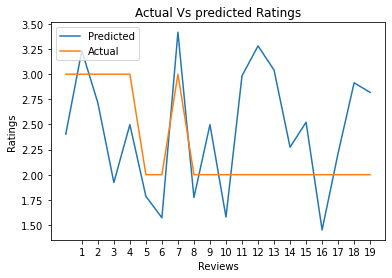

In [ ]:
lim = 119990
plt.plot(lstm_preds[lim:lim+20], label = 'Predicted')
plt.plot(ytest[lim:lim+20], label = 'Actual')
plt.legend(loc = 'upper left')
plt.xlabel("Reviews")
plt.ylabel("Ratings")
plt.xticks(np.arange(1,20))
plt.title("Actual Vs predicted Ratings")
plt.savefig("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/testplots/lstmtestplot.png")

In [ ]:
lstm_model.fit(xtrain_pad, arrytrain, batch_size = 64, epochs = 30,
                validation_data = (xval_pad, arryval))

Epoch 1/30
7500/7500 [==============================] - 209s 28ms/step - loss: 0.7708 - mean_squared_error: 0.7708 - val_loss: 0.5840 - val_mean_squared_error: 0.5840
Epoch 2/30
7500/7500 [==============================] - 208s 28ms/step - loss: 0.5492 - mean_squared_error: 0.5492 - val_loss: 0.5355 - val_mean_squared_error: 0.5355
Epoch 3/30
7500/7500 [==============================] - 212s 28ms/step - loss: 0.4815 - mean_squared_error: 0.4815 - val_loss: 0.5291 - val_mean_squared_error: 0.5291
Epoch 4/30
7500/7500 [==============================] - 211s 28ms/step - loss: 0.4402 - mean_squared_error: 0.4402 - val_loss: 0.5333 - val_mean_squared_error: 0.5333
Epoch 5/30
7500/7500 [==============================] - 213s 28ms/step - loss: 0.4055 - mean_squared_error: 0.4055 - val_loss: 0.5449 - val_mean_squared_error: 0.5449
Epoch 6/30
7500/7500 [==============================] - 212s 28ms/step - loss: 0.3788 - mean_squared_error: 0.3788 - val_loss: 0.5499 - val_mean_squared_error: 0.549

In [ ]:
lstm_yvalpred = lstm_model.predict(xval_pad)
lstm_valpreds = []
for pred in lstm_yvalpred:
  lstm_valpreds.append(pred)

print(len(lstm_valpreds), len(yval))
evaluate_model(lstm_valpreds, yval)

119999 119999
Mean squared error: 0.6995628418842106
Mean absolute error: 0.6208095109315017
r2 score: 0.5665060088418614
Root mean squared error: 0.83639873378922


(0.83639873378922, 0.6995628418842106, 0.6208095109315017, 0.5665060088418614)

In [ ]:
#for future use
lstm_model.save("/content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/lstm_model30")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/cmpe297-guzun/297-final project/297-yelp-data/lstm_model30/assets
